In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from keras.api.models import Model
from keras.api.layers import Input, Dense, Activation, Flatten
from keras.api.optimizers import Adam
from keras.api.losses import binary_crossentropy
import random
import cv2

In [9]:
work_dir = 'c:/Users/Jalil/Desktop/Ecole/M2TSI/tp2/'

In [2]:
datasetnpy_path = 'datasets/dataset.npy'

In [ ]:
dataset_toystory_path = os.path.join(work_dir, 'datasets/Movies/toy_story_1_01')
dataset_ernest_path = os.path.join(work_dir, 'datasets/Movies/ernest_celestine_01')
datasetnpy_path = os.path.join(work_dir, 'datasets/dataset.npy')

dataset = []
for img in os.listdir(dataset_ernest_path):
    dataset.append(plt.imread(os.path.join(dataset_ernest_path, img)))


for img in os.listdir(dataset_toystory_path):
    dataset.append(plt.imread(os.path.join(dataset_toystory_path, img)))

dataset = np.array(dataset)

with open(datasetnpy_path, 'wb') as f:
    np.save(f, dataset)

In [3]:
with open(datasetnpy_path, 'rb') as f:
    dataset = np.load(f)

In [4]:
print(f'dataset_shape : {dataset.shape}')

dataset_shape : (1000, 540, 920, 3)


In [5]:
target = np.zeros(1000)
target[500:] = 1
target = target.reshape((-1,1))

In [6]:
print(f'target_shape : {target.shape}')

target_shape : (1000, 1)


(540, 920)


(<matplotlib.image.AxesImage at 0x2708c73fd60>, (-0.5, 919.5, 539.5, -0.5))

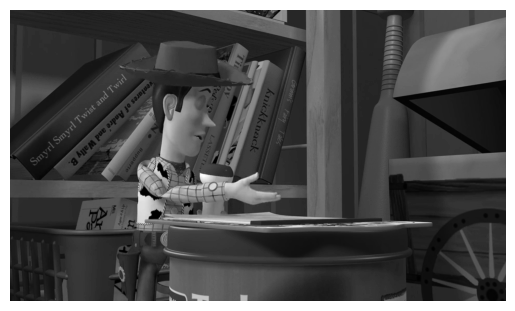

In [46]:
img_test = dataset[710]
img_gray = cv2.cvtColor(img_test, cv2.COLOR_RGB2GRAY)
print(img_gray.shape)
plt.imshow(img_gray, cmap='gray'), plt.axis('off')

(<matplotlib.image.AxesImage at 0x27087b903a0>, (-0.5, 919.5, 539.5, -0.5))

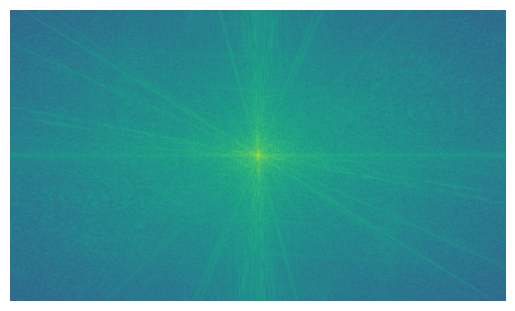

In [58]:
fft = np.fft.fft2(img_gray)
fft_shift = np.fft.fftshift(fft)
fft_shift = np.log(np.abs(fft_shift))
plt.imshow(fft_shift), plt.axis('off')

In [65]:
hist, bin = np.histogram(fft_shift, bins=10)
bin = bin[1:]
print(np.sum(hist))
print(hist), print(bin)
print('--------------------------')
print((hist*bin)/np.sum(hist))

496800
[     6     86   2651  70706 263615 141807  16614   1244     70      1]
[-4.48733305 -2.68830652 -0.88927998  0.90974655  2.70877309  4.50779962
  6.30682616  8.10585269  9.90487923 11.70390577]
--------------------------
[-5.41948436e-05 -4.65367070e-04 -4.74533260e-03  1.29477737e-01
  1.43734545e+00  1.28671003e+00  2.10913063e-01  2.02972640e-02
  1.39561503e-03  2.35585865e-05]


In [68]:
def compute_mean(image):
    image_size = image.shape[0] * image.shape[1] * image.shape[2]
    
    return (np.sum(image.flatten())/image_size)

def compute_mean(image):
    image_size = image.shape[0] * image.shape[1] * image.shape[2]
    return [np.mean(image[:,:,0]), np.mean(image[:,:,1]), np.mean(image[:,:,2])]

def extract_histogram(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hist, bin = np.histogram(img_gray, bins=10)
    bin = bin[1:]
    return (hist*bin/np.sum(hist))

def extract_frequencies(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fft_image = np.log(np.abs(np.fft.fftshift(np.fft.fft2(gray_image))))
    
    hist, bin = np.histogram(fft_shift, bins=10)
    bin = bin[1:]

    return (hist*bin)/np.sum(hist)
        
        

vecteur features : [moyenne, moyenne rgb, histogramme de l'image, histogramme des frequences,]

In [69]:
print(extract_frequencies(img_test))

[-5.41948436e-05 -4.65367070e-04 -4.74533260e-03  1.29477737e-01
  1.43734545e+00  1.28671003e+00  2.10913063e-01  2.02972640e-02
  1.39561503e-03  2.35585865e-05]


In [55]:
print(extract_histogram(img_test))

(array([ 59281, 186077, 103852,  73049,  41908,  19507,   6370,   4396,
         2085,    275], dtype=int64), array([0.        , 0.09932942, 0.19865884, 0.29798827, 0.39731768,
       0.4966471 , 0.59597653, 0.69530594, 0.79463536, 0.89396477,
       0.9932942 ], dtype=float32))


In [56]:
print(np.log10(1000000000000000000))

18.0


In [57]:
print(extract_frequencies(img_test, 100))

(array([  4839, 298766, 189310,   3858,     27], dtype=int64), array([-1.57255466, -0.24905296,  1.07444874,  2.39795045,  3.72145215,
        5.04495385]))


In [8]:
carac_vector = np.zeros(len(dataset))
for i, image in enumerate(dataset):
    carac_vector[i] = compute_mean(image)

carac_vector = carac_vector.reshape((1,-1))
print(f'carac vector shape : {carac_vector.shape}')

carac vector shape : (1, 1000)


In [9]:
y_tab = np.random.choice([0,1], size=(1000,))
print(y_tab.shape)

(1000,)


In [10]:
input = Input(shape=(540,920,3))
x = Flatten()(input)
x = Dense(units=32, activation='relu')(x)
x = Dense(units=16, activation='relu')(x)
output = Dense(units=1, activation='sigmoid')(x)

model = Model(input, output)

In [11]:
model.summary()
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss=binary_crossentropy, metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 540, 920, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1490400)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │    47,692,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,693,377 (181.94 MB)

 Trainable params: 47,693,377 (181.94 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.fit(dataset, y_arr, epochs=5, batch_size=16, shuffle=True)

Epoch 1/5
18/63 ━━━━━━━━━━━━━━━━━━━━ 18s 415ms/step - accuracy: 0.4919 - loss: 332.4404

KeyboardInterrupt: 

In [95]:
model.evaluate(dataset)